<a href="https://colab.research.google.com/github/dshah56/Class-Project/blob/main/DESOPT_Project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Dia Shah**

# **ASU ID: 1222632931**

# **MAE 598: Design Optimization**

# **Project 1 _ Rocket Landing OPtimization**




**These are some of the papers I referred for the project**

*https://www.ri.cmu.edu/pub_files/2009/5/icra09-chomp.pdf*

*https://www.sciencedirect.com/science/article/abs/pii/S0094576522003794?via%3Dihub*

*https://arc.aiaa.org/doi/10.2514/1.G003518*


In [ ]:
# overhead
import logging
import math
import random
import numpy as np
import time
import torch 
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt


from ipywidgets import IntProgress
from IPython.display import display
from matplotlib import pyplot as plt, rc
from matplotlib.animation import FuncAnimation, PillowWriter, FFMpegWriter
rc('animation', html='jshtml')
!pip install jupyterthemes
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

logger = logging.getLogger(__name__)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.0 MB 4.2 MB/s 
     |████████████████████████████████| 46 kB 1.3 MB/s 
     |████████████████████████████████| 1.6 MB 41.9 MB/s 
     |████████████████████████████████| 49 kB 2.8 MB/s 


# **Rocket State & Trajectory**
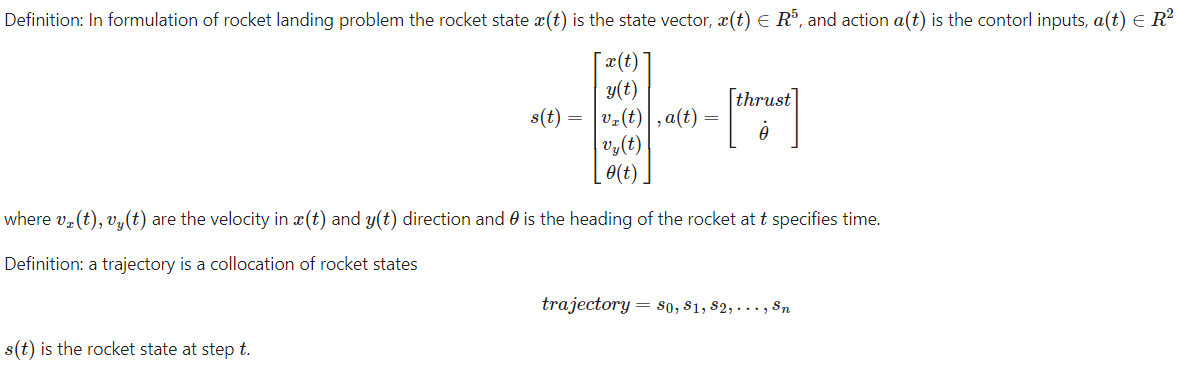

In [2]:
# environmental parameters
TimeFrame = 0.1  # time interval
Gravity_y = 0.12  # gravity constant in Y direction
Gravity_x =0.
Boost_acc = 0.18  # thrust constant
Cd = 1
rho = 0.07967 # density 
A =1 # cross sectional area of rocket

# **Dynamics of Model**
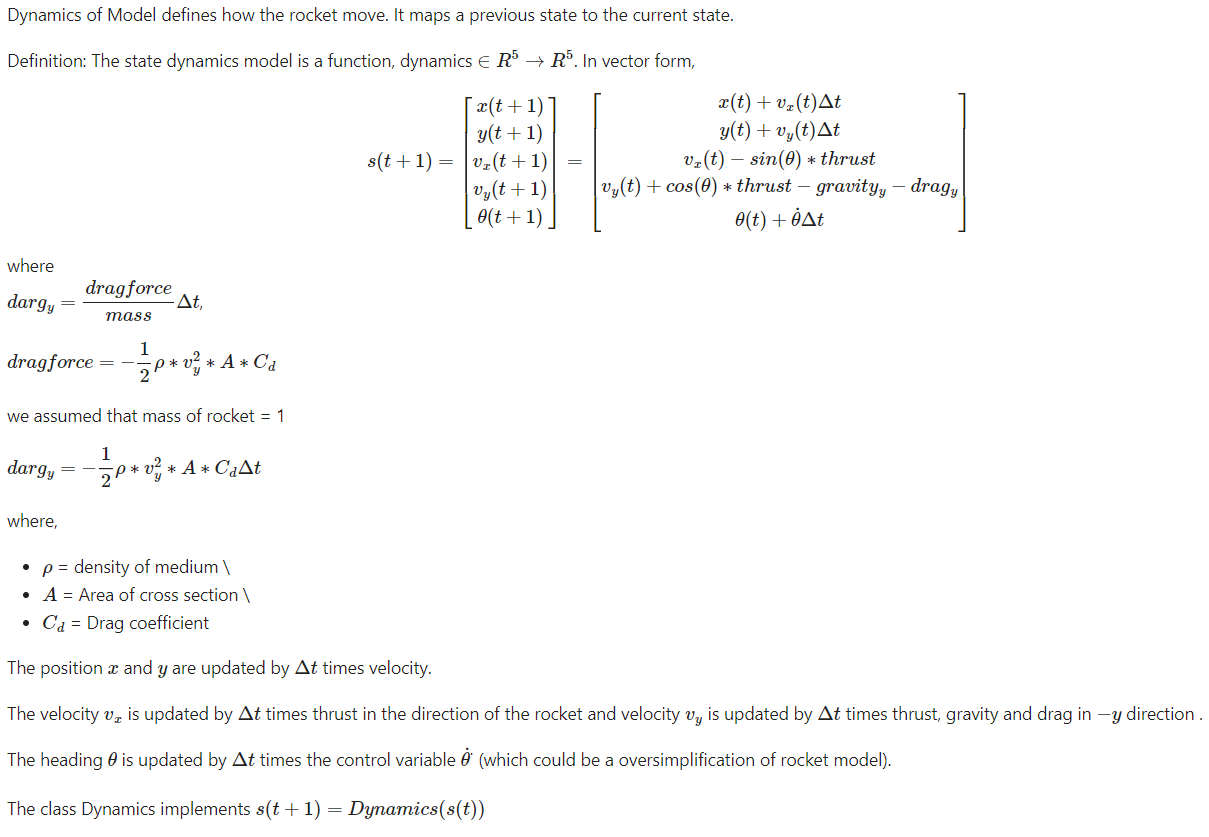

In [3]:
class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    def forward(self, state, action):
        """
        action[0] = Thrust
        action[1] = theta_dot

        state[0] = x
        state[1] = y
        state[2] = vx
        state[3] = vy
        state[4] = theta
      
        """
        # Apply gravity
        # Note: Here gravity is used to change velocity which is the second element of the state vector
        # Normally, we would do x[1] = x[1] + gravity * delta_time
        # but this is not allowed in PyTorch since it overwrites one variable (x[1]) that is part of the computational graph to be differentiated.
        # Therefore, I define a tensor dx = [0., gravity * delta_time], and do x = x + dx. This is allowed... @cc antantantant (Prof Max Yi Ren)

        delta_state_gravity = torch.tensor([0., 0.,-Gravity_x * TimeFrame, -Gravity_y * TimeFrame, 0.])

        state_tensor = torch.zeros((1, 5))
        state_tensor[0, 3] = torch.cos(state[0, 4])
        state_tensor[0, 2] = -torch.sin(state[0, 4])
    
        delta_state = Boost_acc * TimeFrame * torch.mul(state_tensor, action[0, 0].reshape(-1, 1))

        # Theta
        delta_state_theta = TimeFrame * torch.mul(torch.tensor([0., 0., 0., 0, 1.]),(action[0, 1]).reshape(-1, 1)) 

        #for drag
        Vy = torch.matmul(state,torch.tensor([0., 0., 0., 1., 0.]))

        drag_y = -0.5*rho*Vy*Vy*A*Cd

        state = state + delta_state  + delta_state_gravity + delta_state_theta - drag_y 

        # Update state
        step_mat = torch.tensor([[1., 0.,TimeFrame, 0., 0.],
                                 [0., 1., 0., TimeFrame, 0.],
                                 [0., 0., 1., 0., 0.],
                                 [0., 0., 0., 1., 0.],
                                 [0., 0., 0., 0., 1.]])
        

        state = torch.matmul(step_mat, state.T)
        return (state.T)

# **Controller**
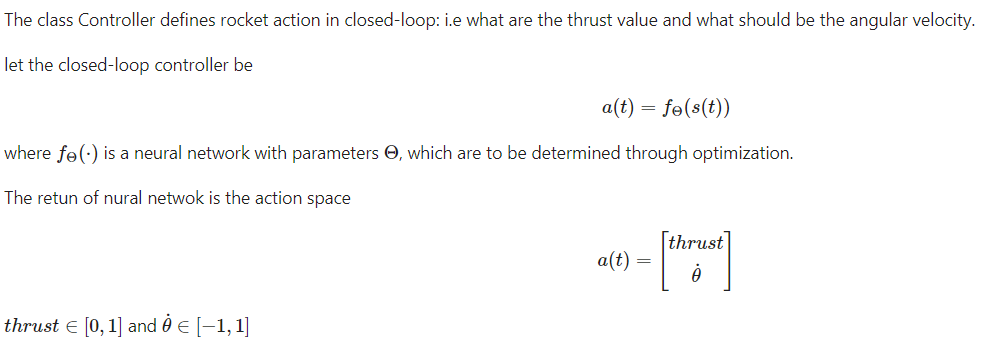

In [4]:
class Controller(nn.Module):
    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: 
        """
        super(Controller, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_output),
            nn.Sigmoid())

    def forward(self, state):
        action = self.network(state)
        action = (action - torch.tensor([0., 0.5]))*2  # bound theta_dot range -1 to 1
        return action

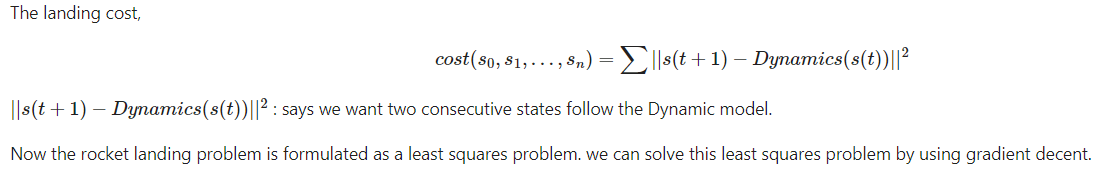

In [5]:
class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.theta_trajectory = torch.empty((1, 0))
        self.u_trajectory = torch.empty((1, 0))

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller(state)
            state = self.dynamics(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():
        # state = [1., 0.]  # TODO: need batch of initial states
        state = [[1.,3.,0.,0.,0.]]
        return torch.tensor(state, requires_grad=False).float()

    def error(self, state):
        return torch.mean(state ** 2)

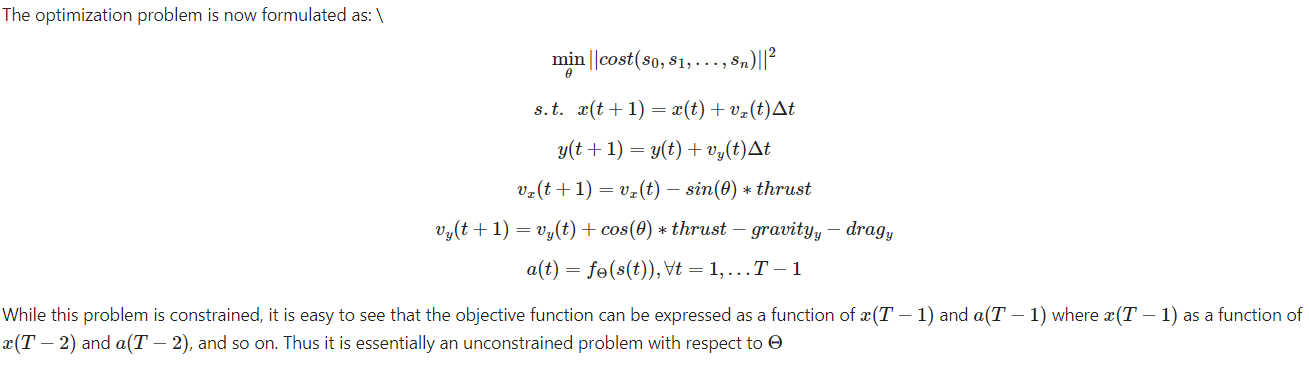

In [28]:
class Optimize:
    
    # create properties of the class (simulation, parameters, optimizer, lost_list). Where to receive input of objects
    
    def __init__(self, simulation):
        self.simulation = simulation # define the objective function
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.01) # define the opmization algorithm
        self.loss_list = []

    # Define loss calculation method for objective function
    
    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)  # calculate the loss of objective function
            self.optimizer.zero_grad()
            loss.backward() # calculate the gradient
            return loss

        self.optimizer.step(closure)
        return closure()

    # Define training method for the model
    

    def train(self, epochs):
        # self.optimizer = epoch
        l = np.zeros(epochs)
        for epoch in range(epochs):
            self.epoch = epoch
            loss = self.step() # use step function to train the model
            self.loss_list.append(loss) # add loss to the loss_list
            print('[%d] loss: %.3f' % (epoch + 1, loss))

            l[epoch]=loss
            self.visualize()
            
        plt.plot(list(range(epochs)), l)
            
        plt.title('Objective Function Convergence Curve')
        plt.xlabel('Training Iteration')
        plt.ylabel('Error')
        plt.show()
        self.animation()
        
    # Define result visualization method

    def visualize(self):
        data = np.array([self.simulation.state_trajectory[i][0].detach().numpy() for i in range(self.simulation.T)])
        x = data[:, 0]
        y = data[:, 1]
        vx = data[:, 2]
        vy = data[:, 3]
        theta = data[:, 4]
        action_data = np.array([self.simulation.action_trajectory[i][0].detach().numpy() for i in range(self.simulation.T)])
        thrust = action_data[:,0]
        frame = range(self.simulation.T)

        fig, ax = plt.subplots(1, 4, tight_layout = 1, figsize = (15, 5))

        ax[0].plot(x, y, c = 'b')
        ax[0].set_xlabel("X")
        ax[0].set_ylabel("Y")
        ax[0].set(title=f'Displacement plot(x-y) at frame {self.epoch}')

        ax[1].plot(frame, vx, c = 'c', label = "Velocity in x")
        ax[1].plot(frame, vy, c = 'r', label = "Velocity in y")
        ax[1].set_xlabel("Time")
        ax[1].set_ylabel("Velocity (m/s)")
        ax[1].legend(frameon=0)
        ax[1].set(title =f'Velocity plot at frame {self.epoch}')

        ax[2].plot(frame, theta, c = 'g', label = "theta")
        ax[2].set_xlabel("Time interval")
        ax[2].set_ylabel("Theta")
        ax[2].legend(frameon=0)
        ax[2].set(title=f'Theta plot at {self.epoch}')

        ax[3].plot(frame, thrust, c = 'y', label = "thrust")
        ax[3].set_xlabel("Time interval")
        ax[3].set_ylabel("Thrust")
        ax[3].legend(frameon=0)
        ax[3].set(title=f'Thrust plot at {self.epoch}')
        plt.show()

    def animation(self):
              # Size
        length = 0.05          # m
        width = 0.01          # m

        #
        v_exhaust = 3     
        print("Generating Animation")
        steps = 100 + 1
        final_time_step = round(1/steps,2)
        f = IntProgress(min = 0, max = steps)
        display(f)

        data = np.array([self.simulation.state_trajectory[i][0].detach().numpy() for i in range(self.simulation.T)])
        action_data = np.array([self.simulation.action_trajectory[i][0].detach().numpy() for i in range(self.simulation.T)])

        x_t = data
        u_t = action_data
        print(x_t.shape, u_t.shape)

        fig = plt.figure(figsize = (5,8), constrained_layout=False)
        ax1 = fig.add_subplot(111)
        plt.axhline(y=0., color='b', linestyle='--', lw=0.8)

        ln6, = ax1.plot([], [], '--', linewidth = 2, color = 'orange') # trajectory line
        ln2, = ax1.plot([], [], linewidth = 2, color = 'tomato') # thrust line
        ln1, = ax1.plot([], [], linewidth = 7, color = 'lightblue') # rocket body

        plt.tight_layout()

        ax1.set_xlim(-5, 5)
        ax1.set_ylim(-2, 5)
        ax1.set_aspect(1)  # aspect of the axis scaling, i.e. the ratio of y-unit to x-unit

        def update(i):
            rocket_theta = x_t[i, 4]

            rocket_x = x_t[i, 0]
            # length/1 is just to make rocket bigger in animation
            rocket_x_points = [rocket_x + length/1 * np.sin(rocket_theta), rocket_x - length/1 * np.sin(rocket_theta)]

            rocket_y = x_t[i, 1]
            rocket_y_points = [rocket_y + length/1 * np.cos(rocket_theta), rocket_y - length/1 * np.cos(rocket_theta)]

            ln1.set_data(rocket_x_points, rocket_y_points)

            thrust_mag = u_t[i, 0]
            thrust_angle = -u_t[i, 1]

            flame_length = (thrust_mag) * (0.4/v_exhaust)
            flame_x_points = [rocket_x_points[1], rocket_x_points[1] + flame_length * np.sin(thrust_angle - rocket_theta)]
            flame_y_points = [rocket_y_points[1], rocket_y_points[1] - flame_length * np.cos(thrust_angle - rocket_theta)]

            ln2.set_data(flame_x_points, flame_y_points)
            ln6.set_data(x_t[:i, 0], x_t[:i, 1])
            f.value += 1

        playback_speed = 6500 # the higher the slower 
        anim = FuncAnimation(fig, update, np.arange(0, steps-1, 1), interval= final_time_step * playback_speed)

        anim
        anim.save('/content/sample_data/rocket_landing.avi')

In [29]:
k=np.hstack([[0,0,0,],0,1,2,3])

[1] loss: 4.459


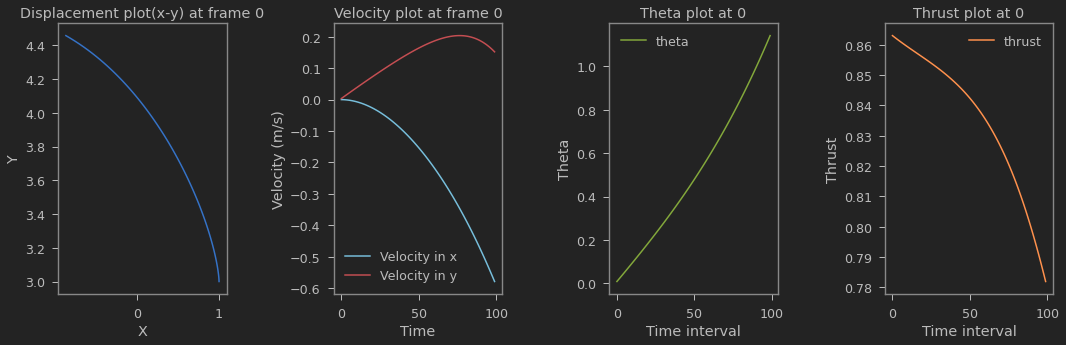

[2] loss: 3.352


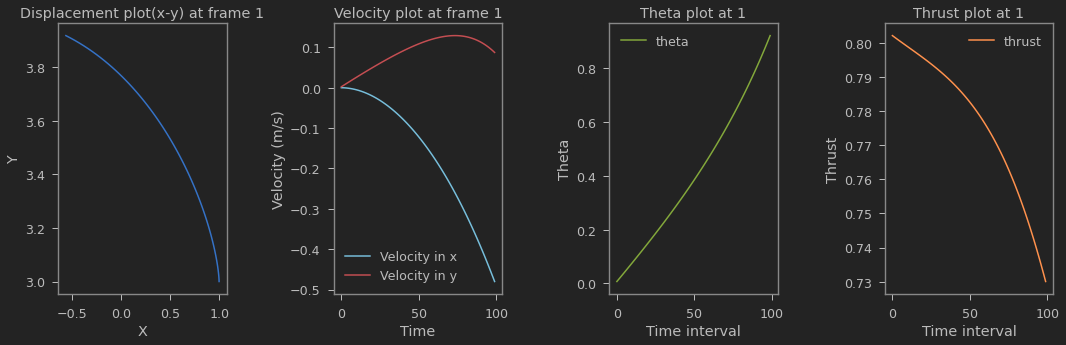

[3] loss: 2.474


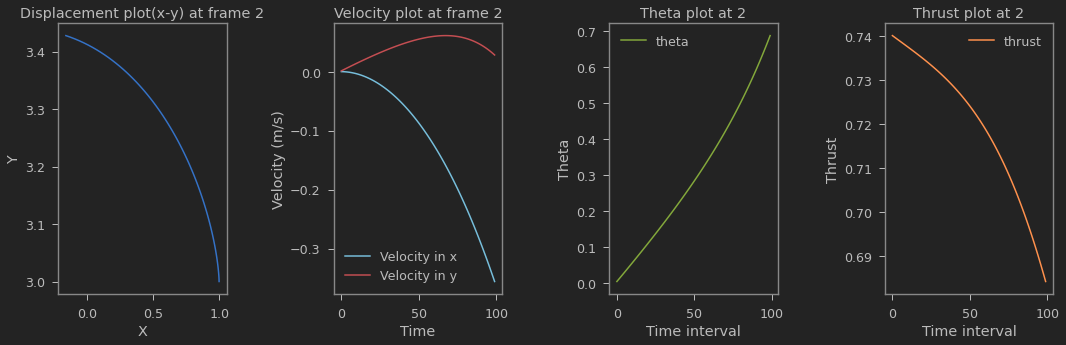

[4] loss: 1.819


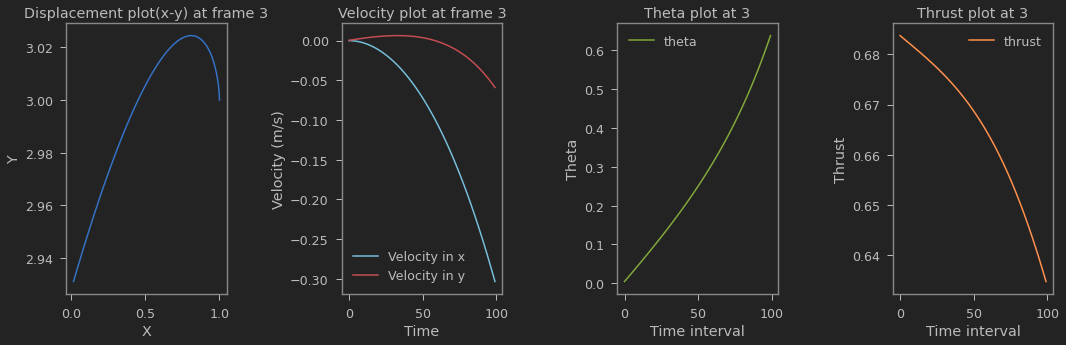

[5] loss: 1.402


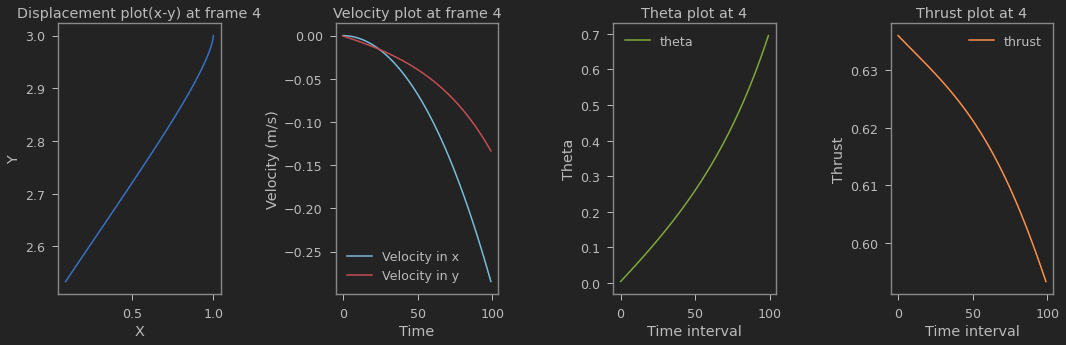

[6] loss: 1.120


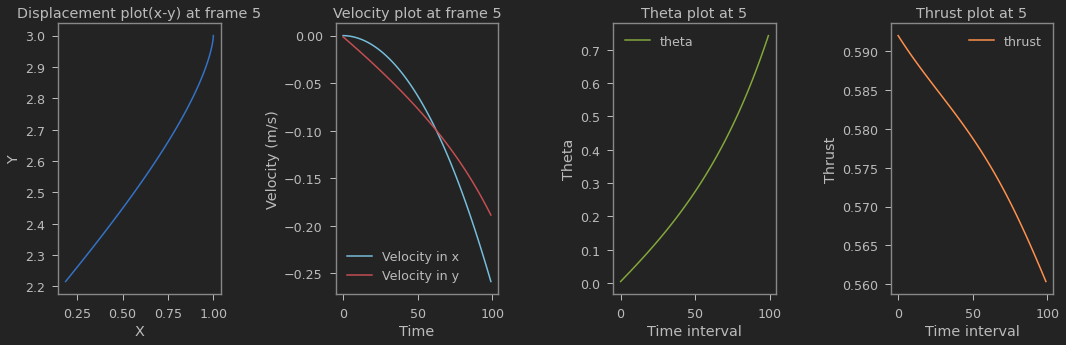

[7] loss: 0.912


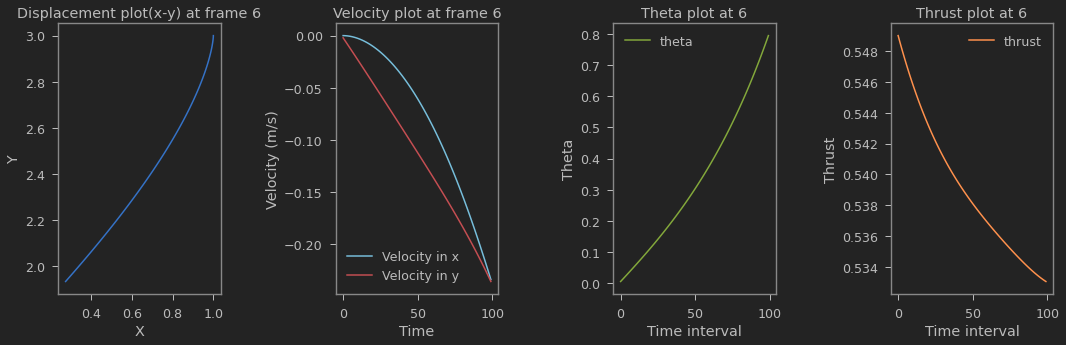

[8] loss: 0.768


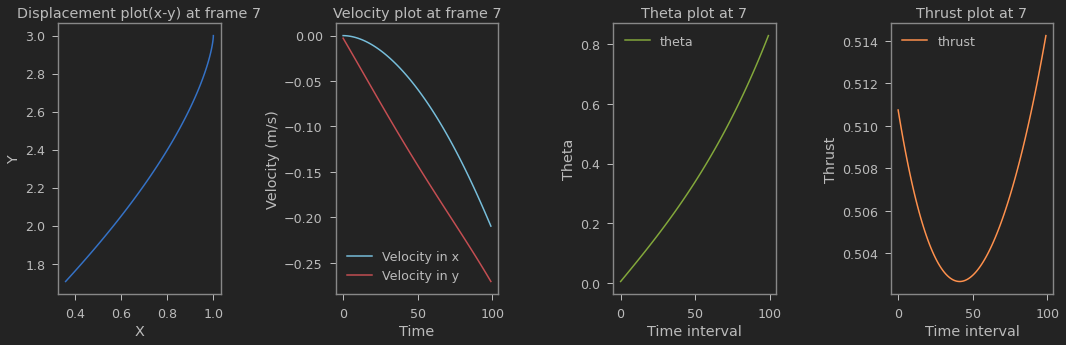

[9] loss: 0.651


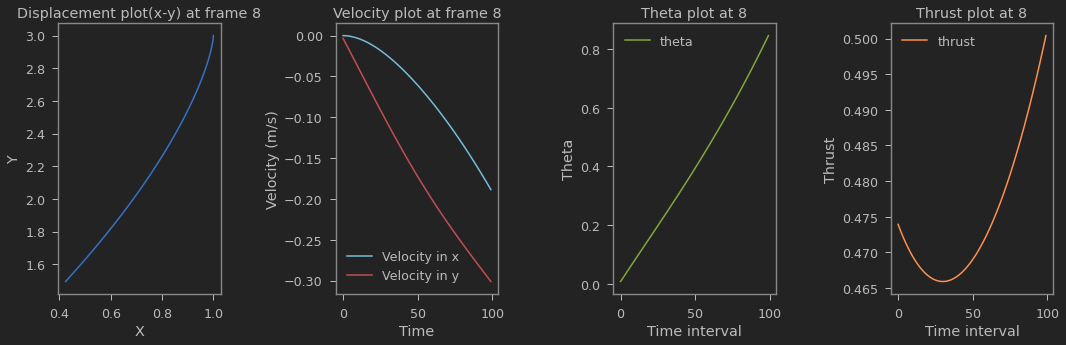

[10] loss: 0.491


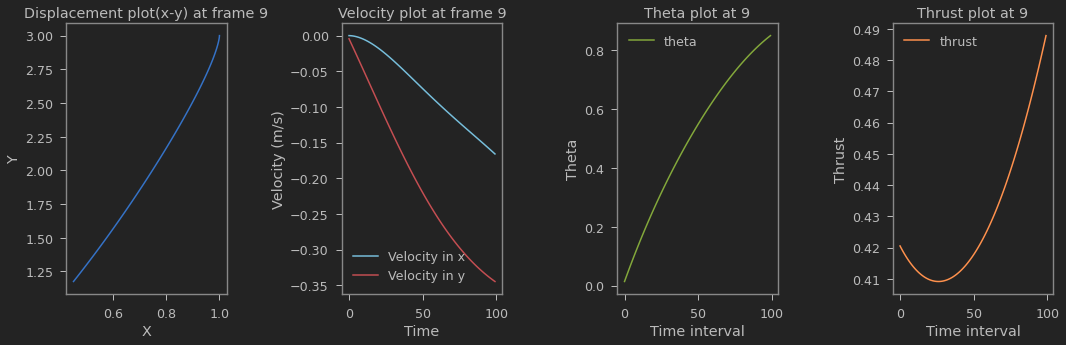

[11] loss: 0.322


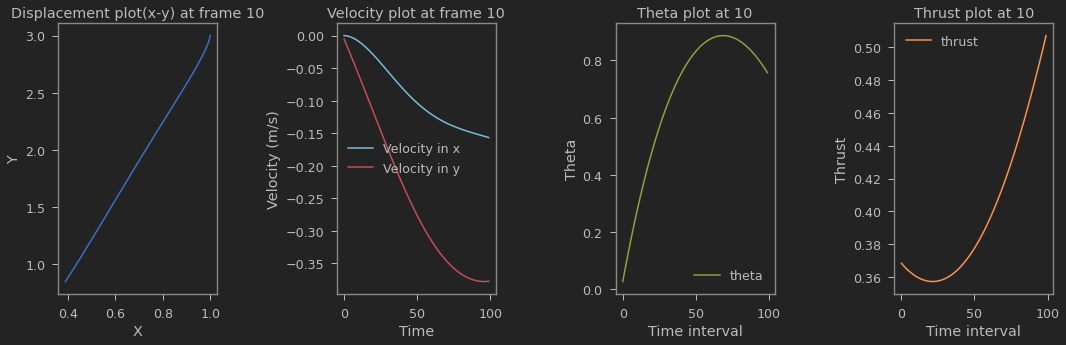

[12] loss: 0.133


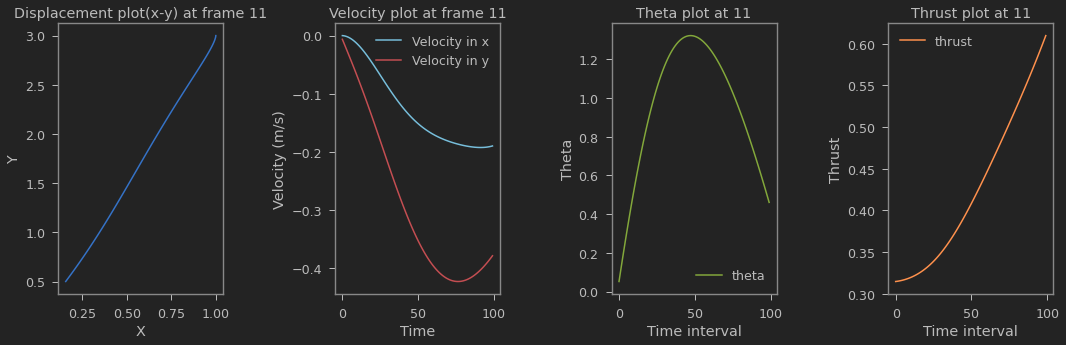

[13] loss: 0.076


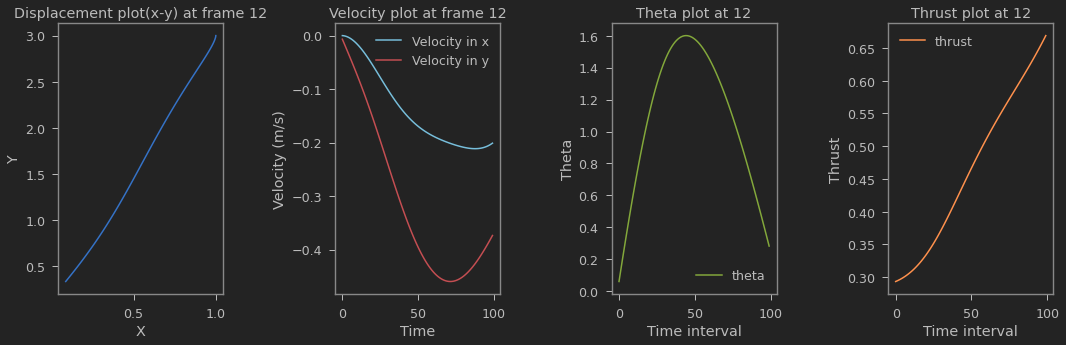

[14] loss: 0.054


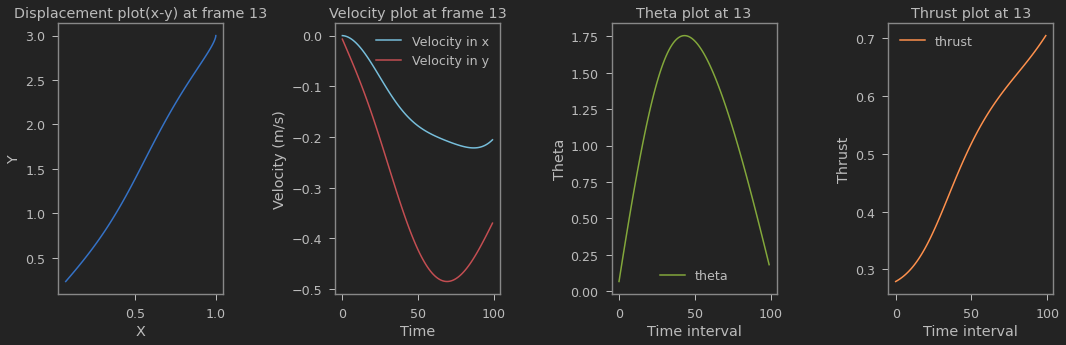

[15] loss: 0.045


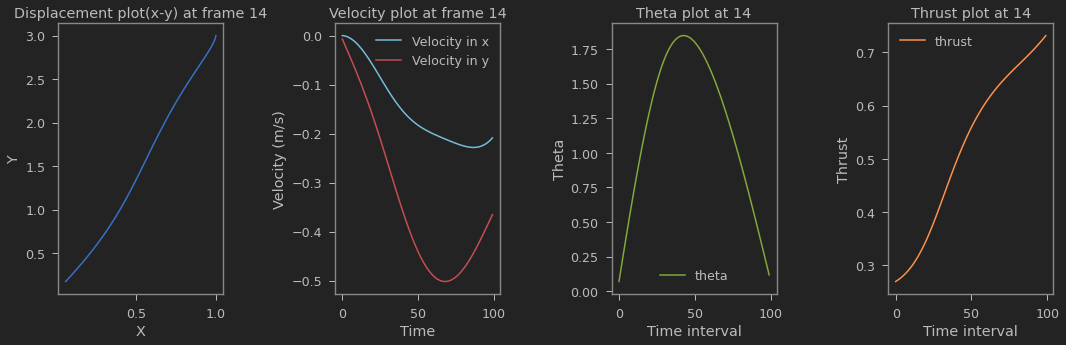

[16] loss: 0.040


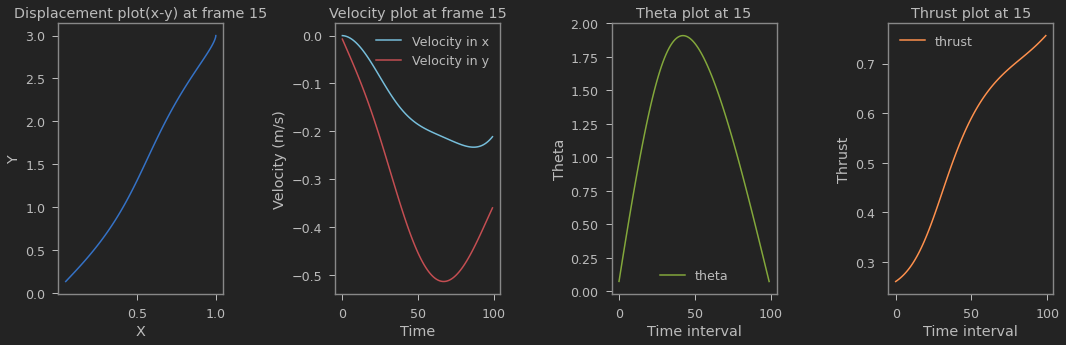

[17] loss: 0.037


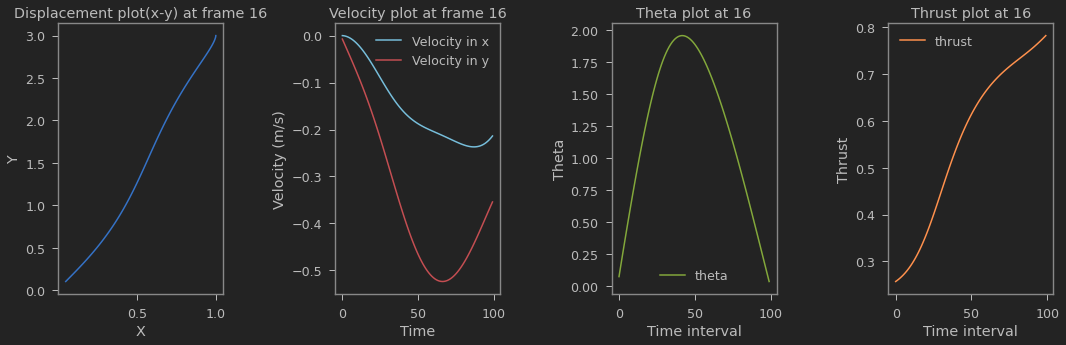

[18] loss: 0.035


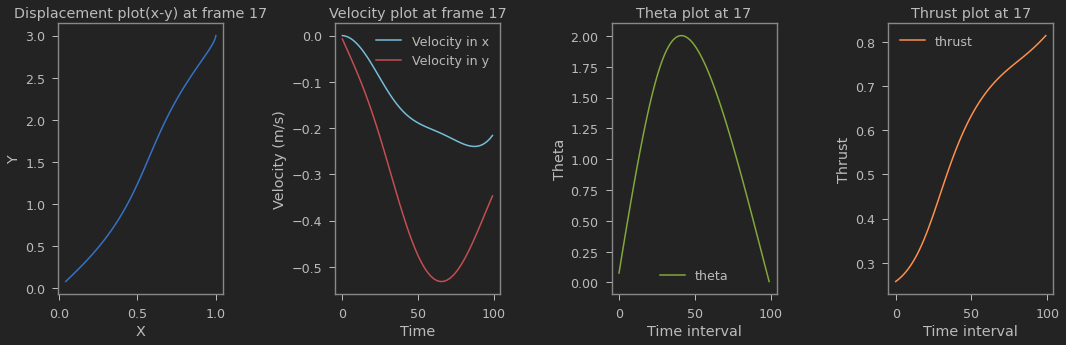

[19] loss: 0.033


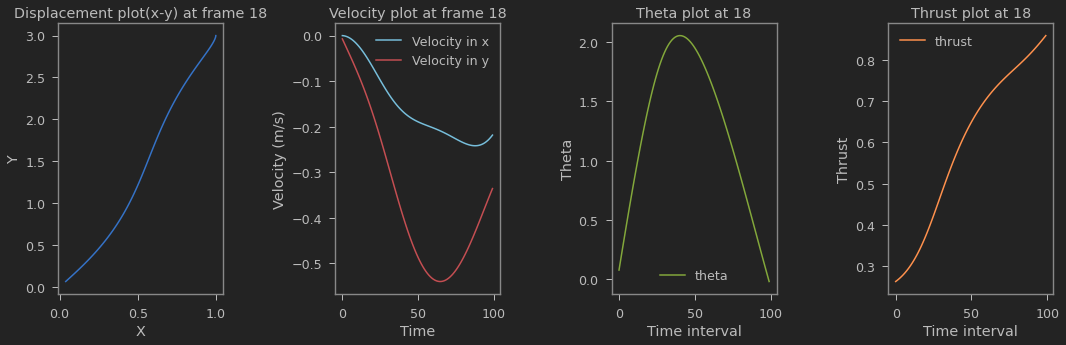

[20] loss: 0.030


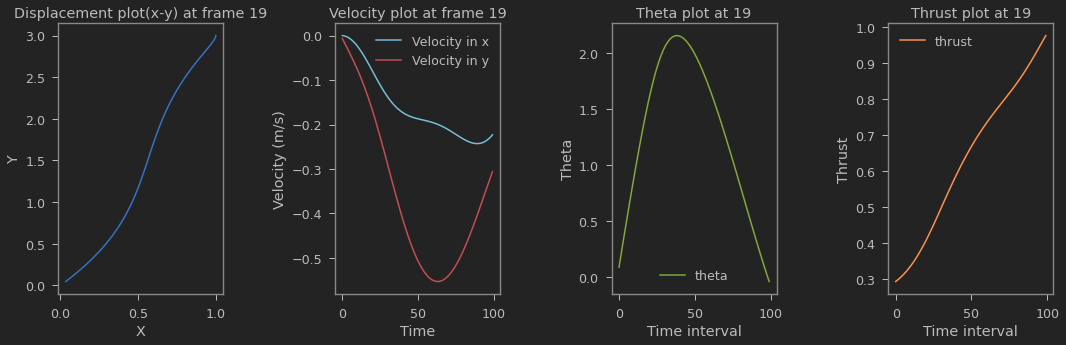

[21] loss: 0.023


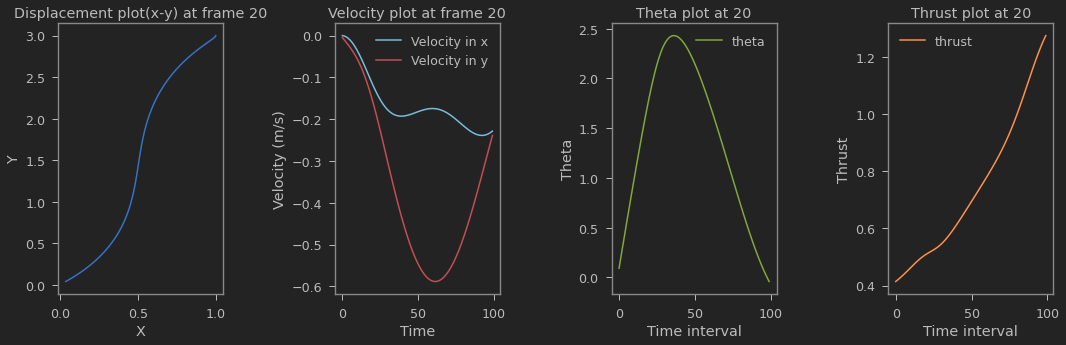

[22] loss: 0.017


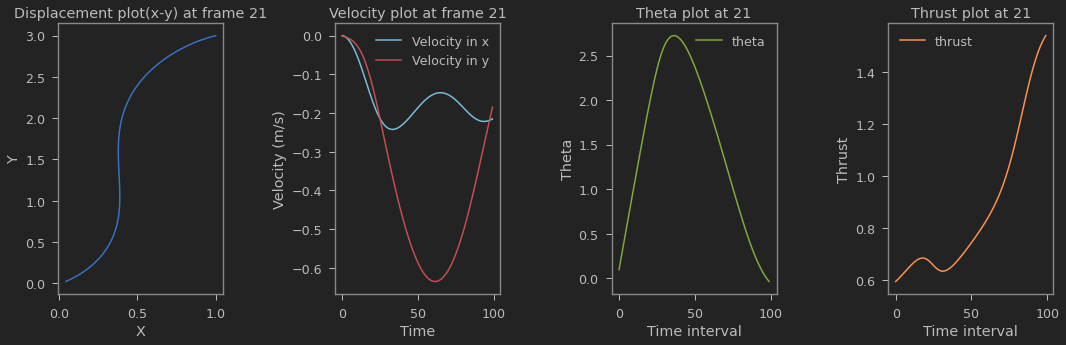

[23] loss: 0.011


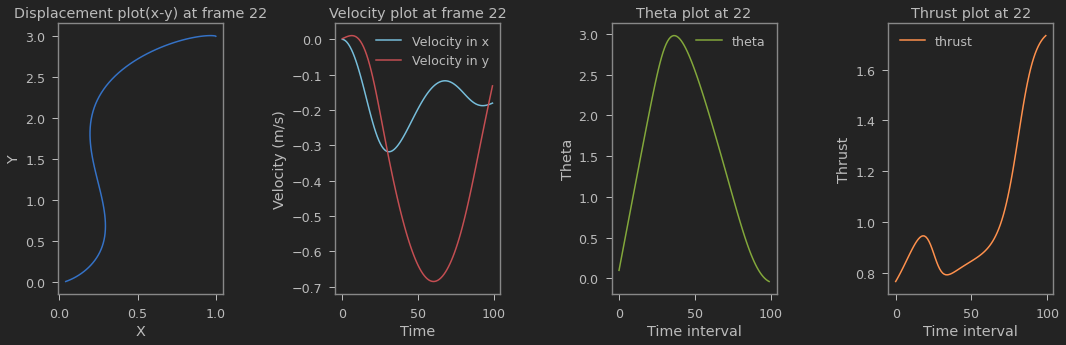

[24] loss: 0.007


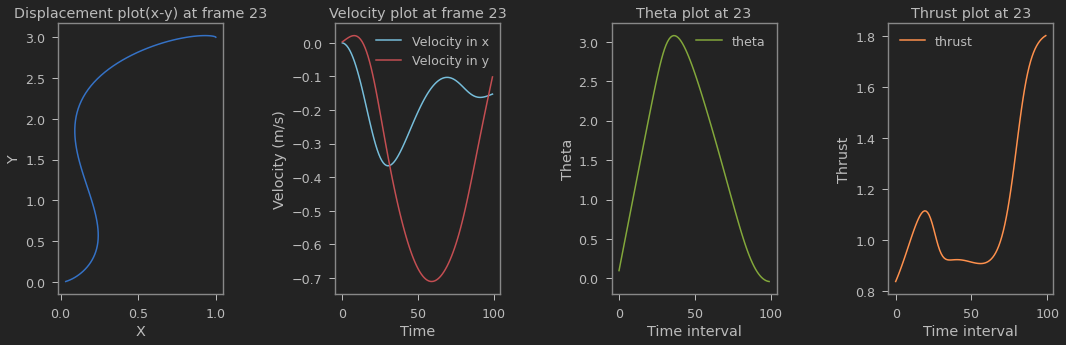

[25] loss: 0.005


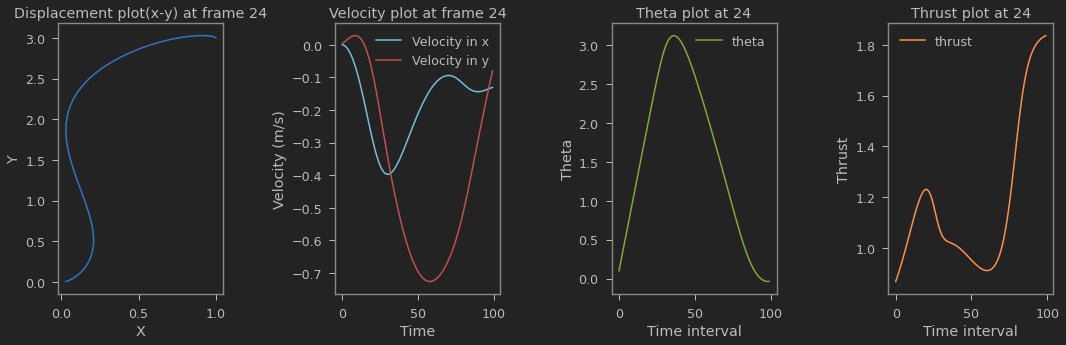

[26] loss: 0.004


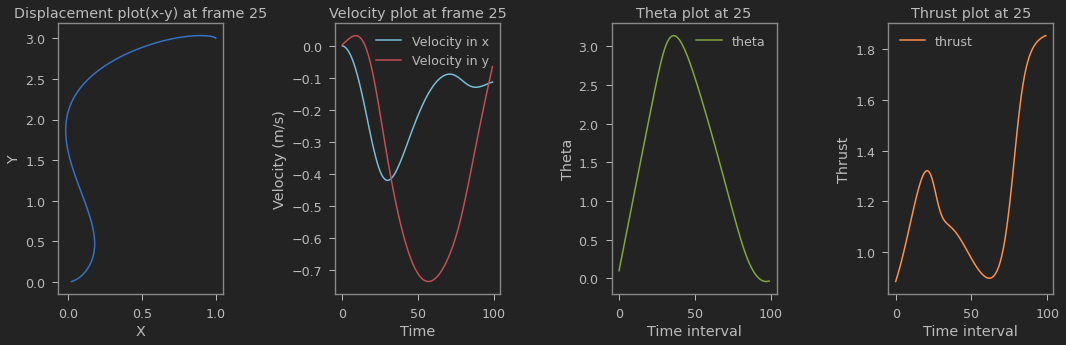

[27] loss: 0.003


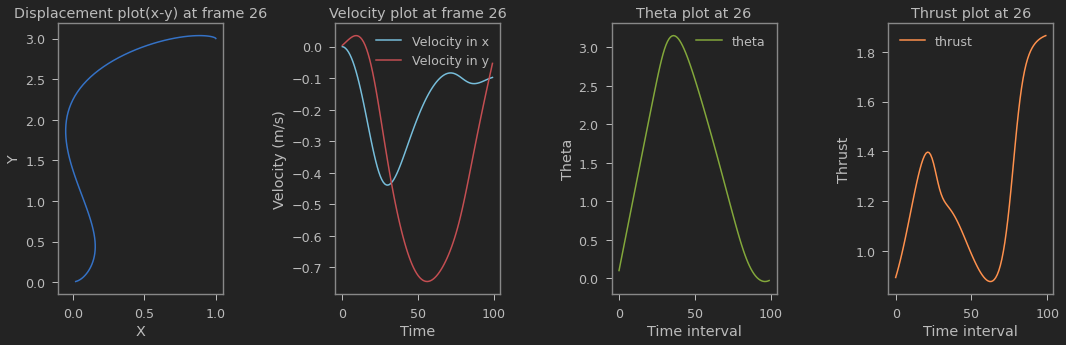

[28] loss: 0.002


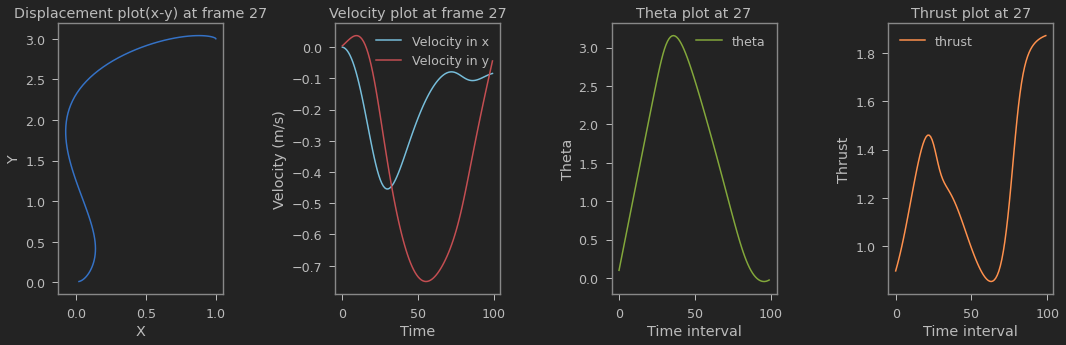

[29] loss: 0.002


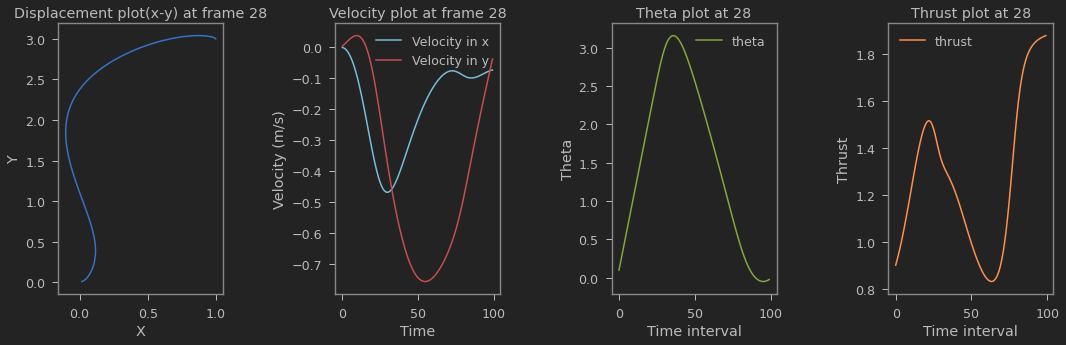

[30] loss: 0.001


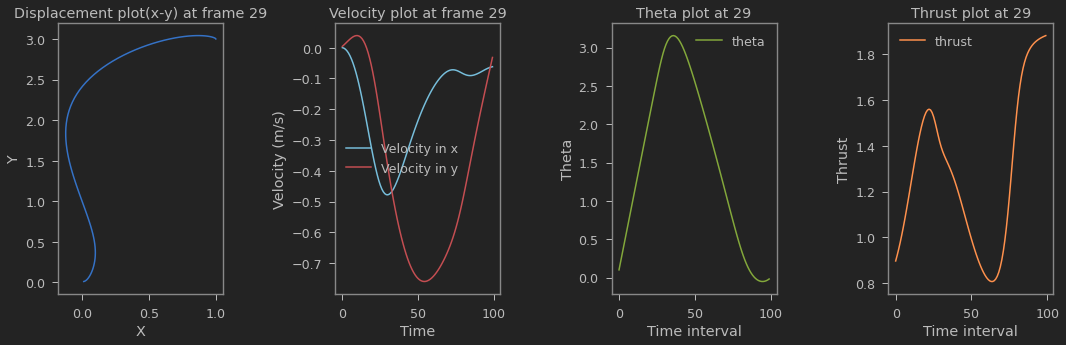

[31] loss: 0.001


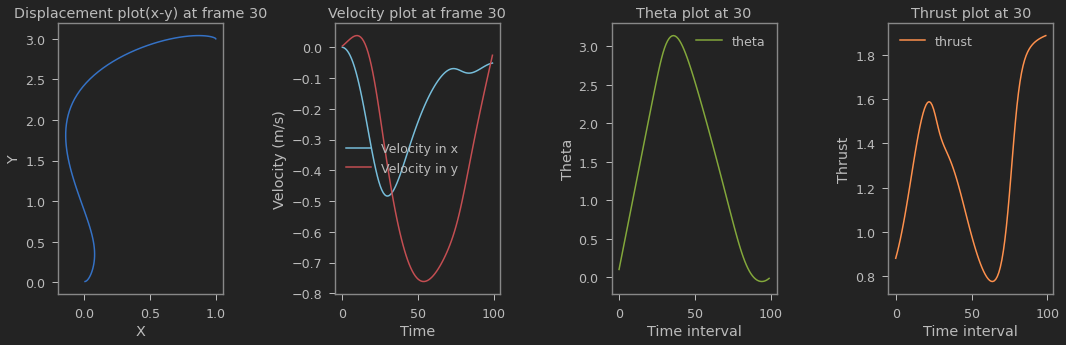

[32] loss: 0.001


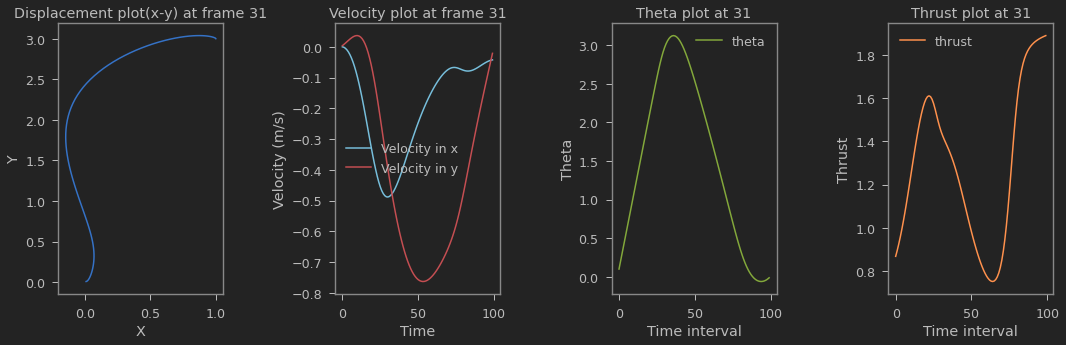

[33] loss: 0.000


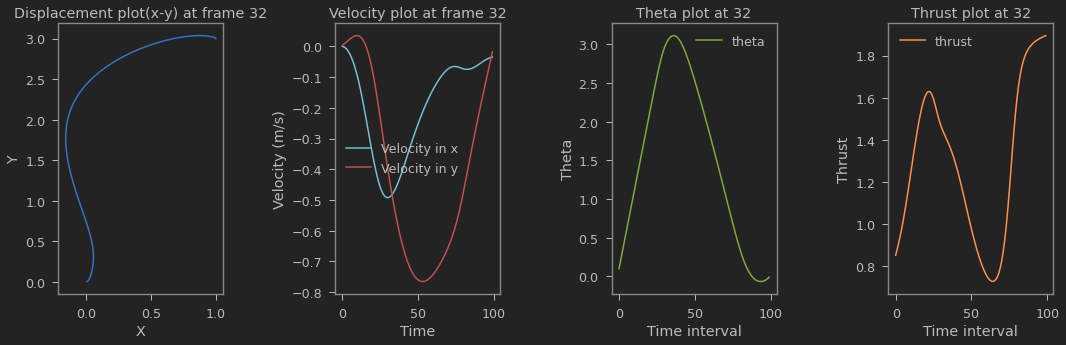

[34] loss: 0.000


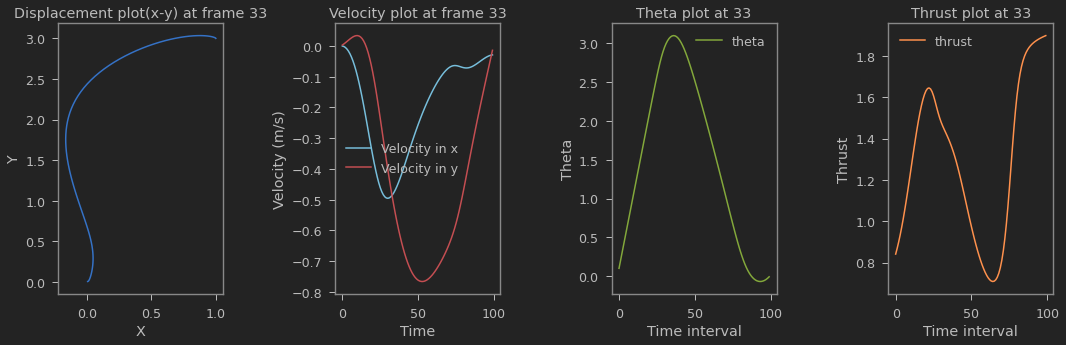

[35] loss: 0.000


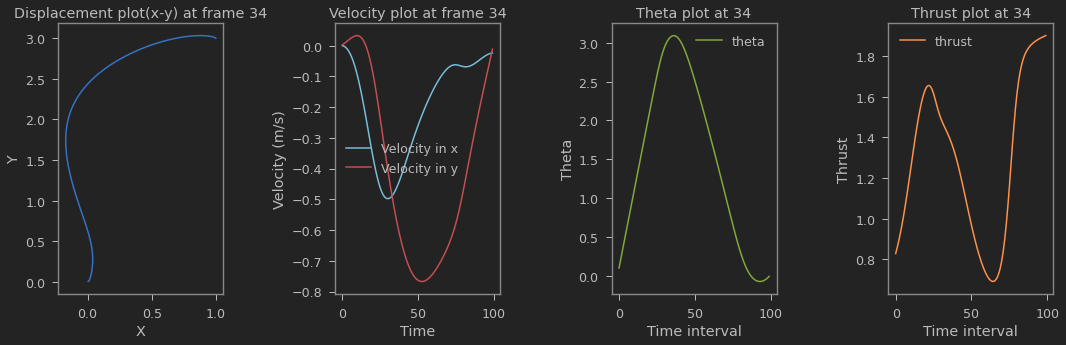

[36] loss: 0.000


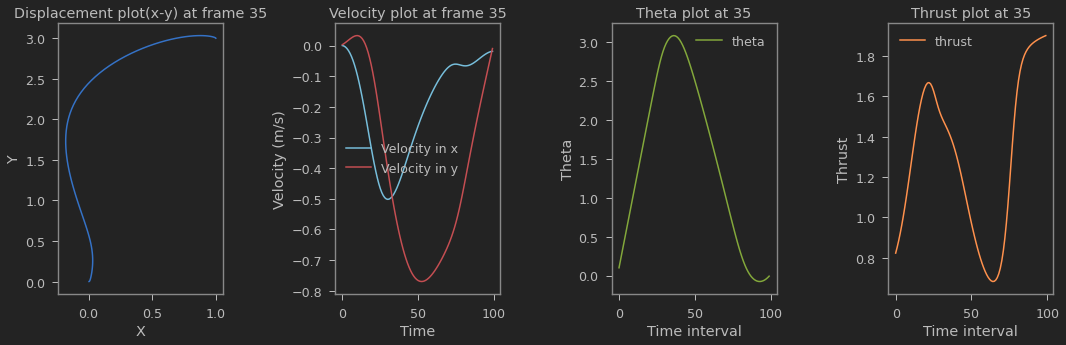

[37] loss: 0.000


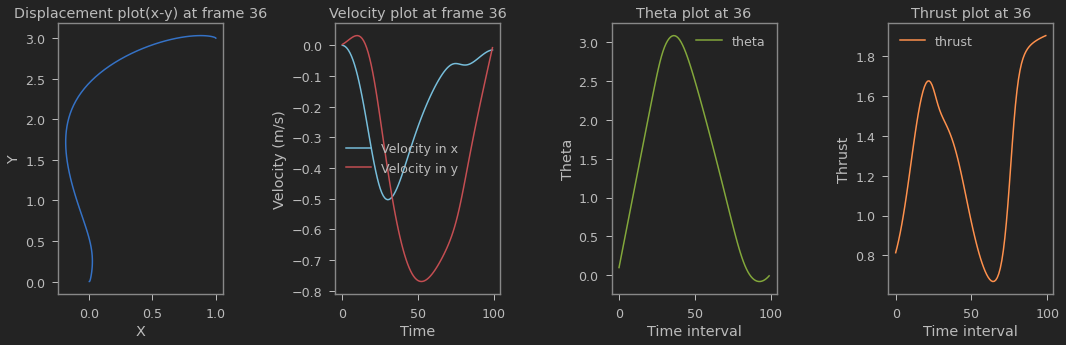

[38] loss: 0.000


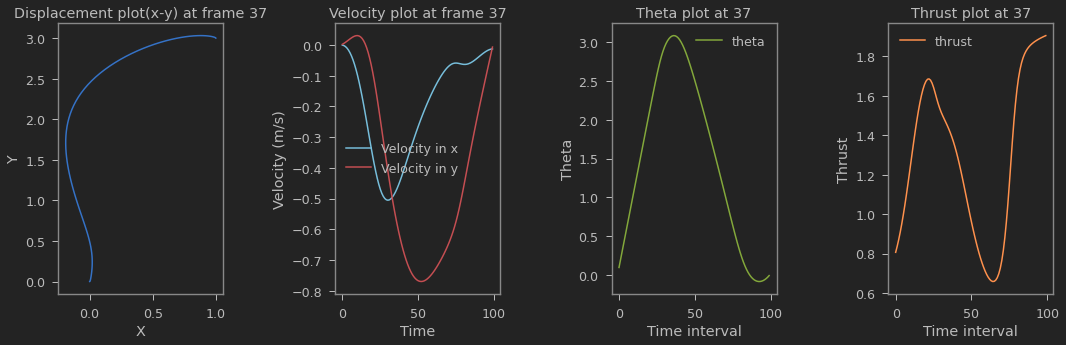

[39] loss: 0.000


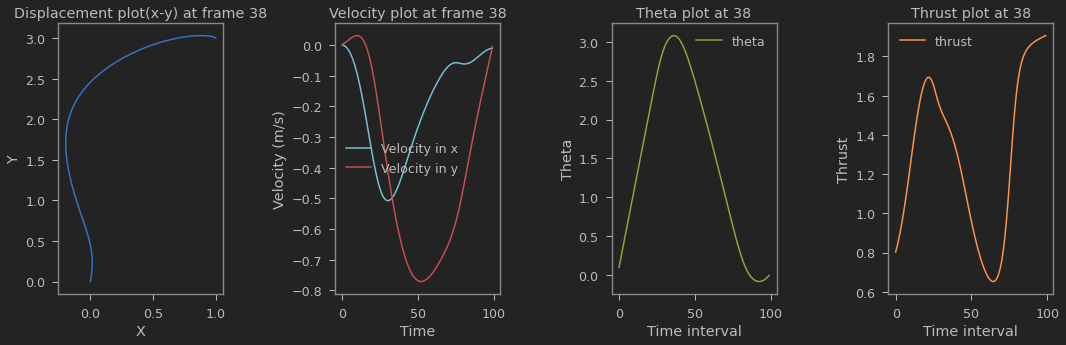

[40] loss: 0.000


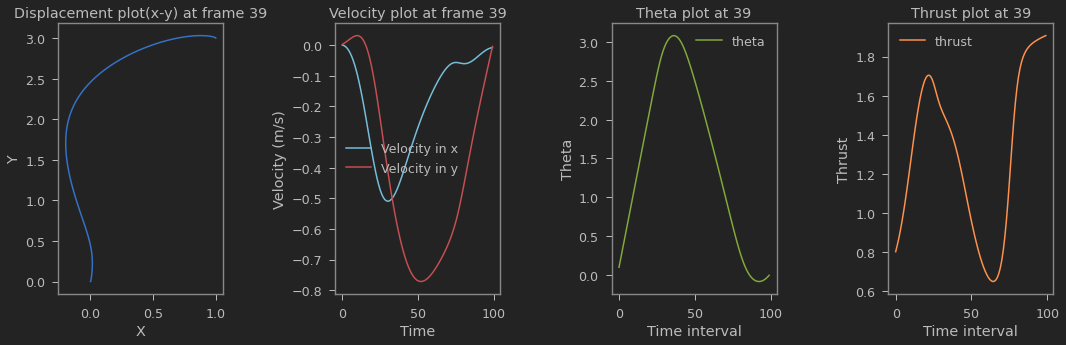

[41] loss: 0.000


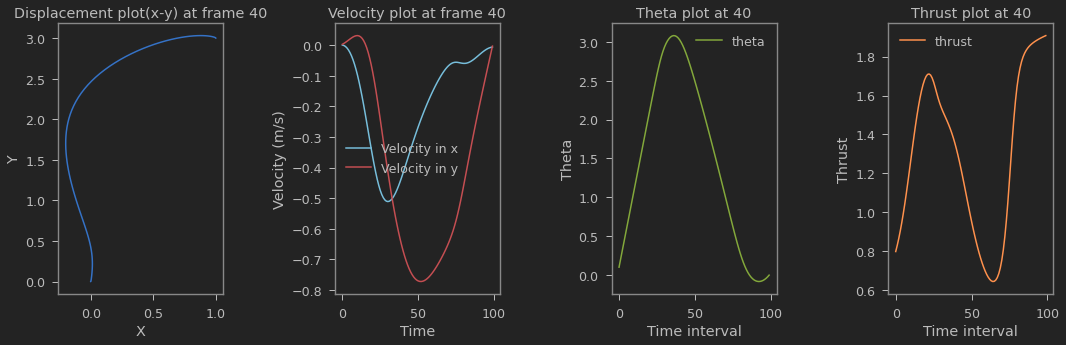

[42] loss: 0.000


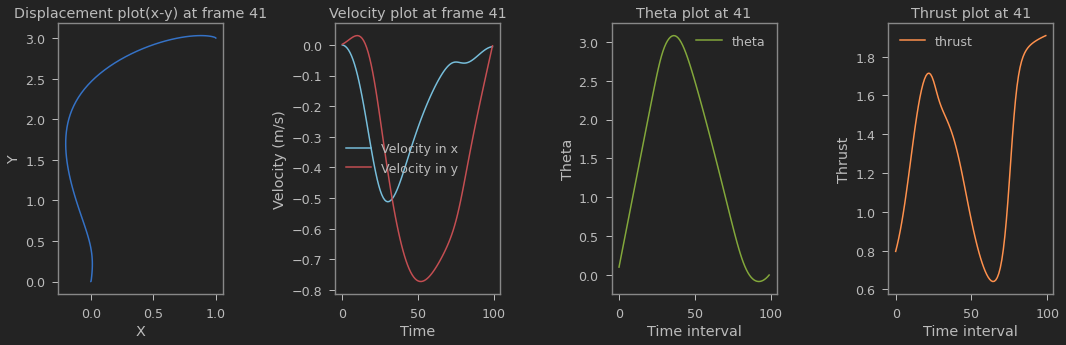

[43] loss: 0.000


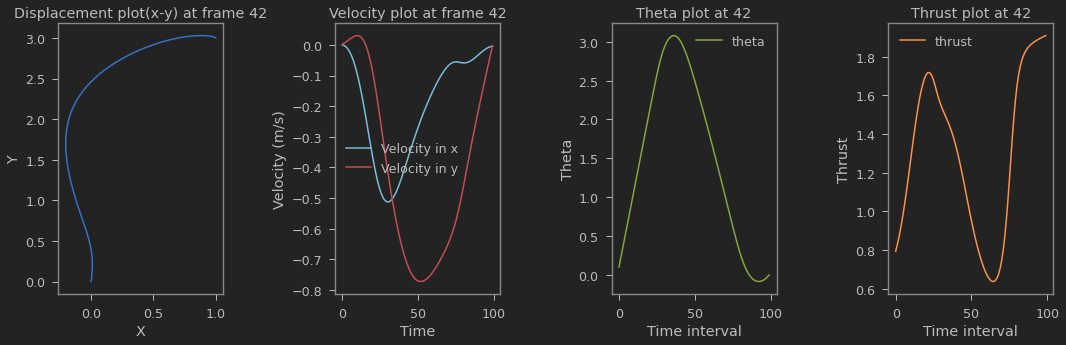

[44] loss: 0.000


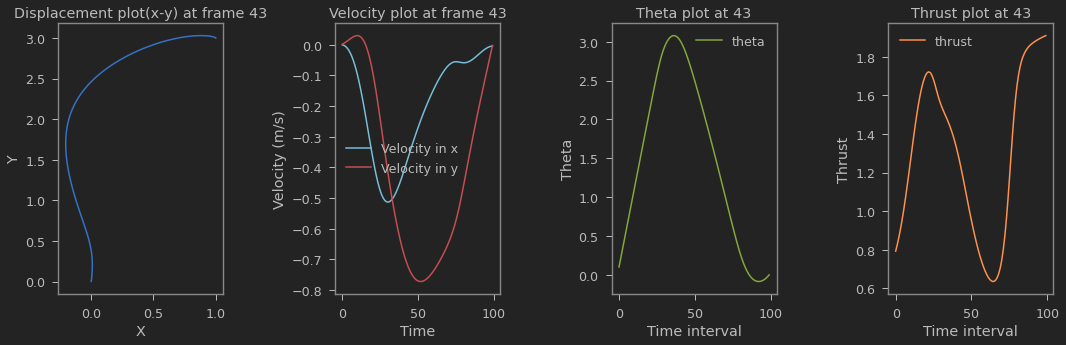

[45] loss: 0.000


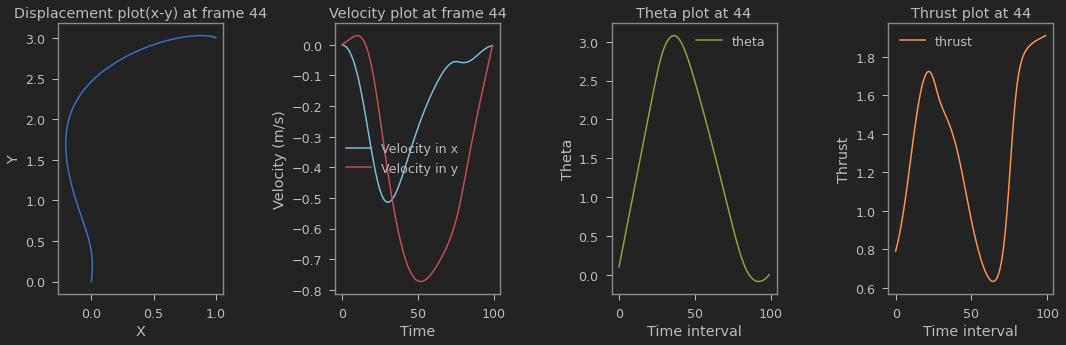

[46] loss: 0.000


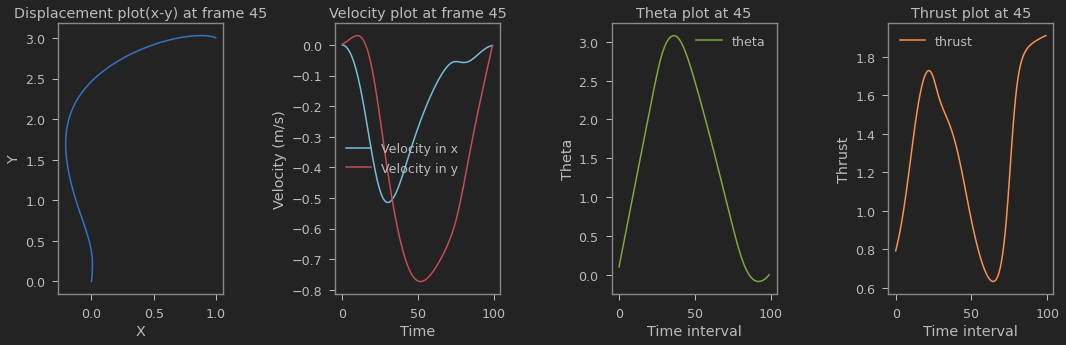

[47] loss: 0.000


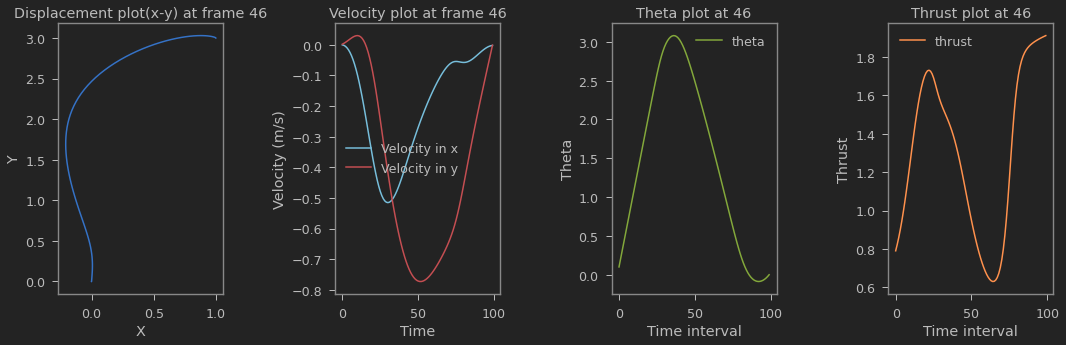

[48] loss: 0.000


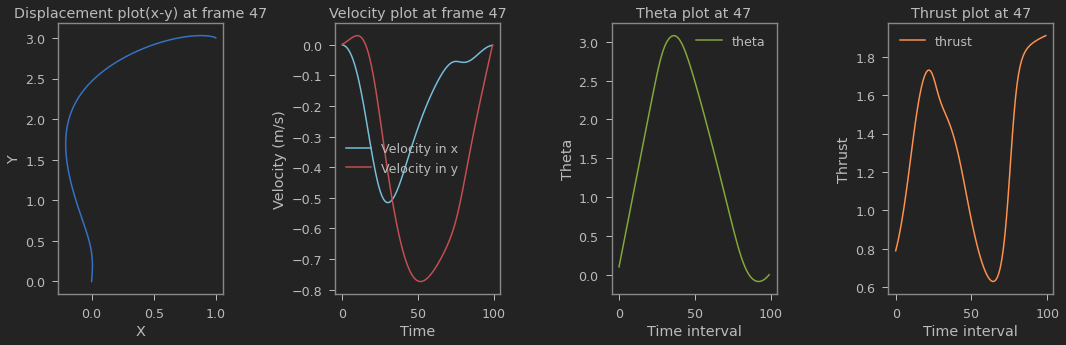

[49] loss: 0.000


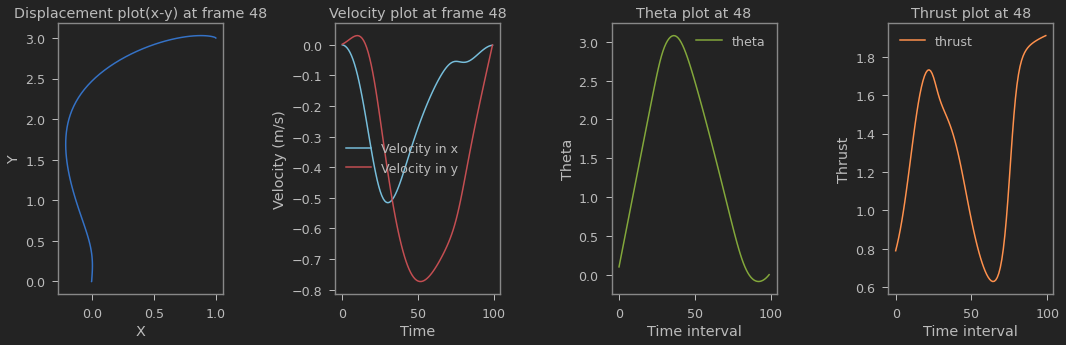

[50] loss: 0.000


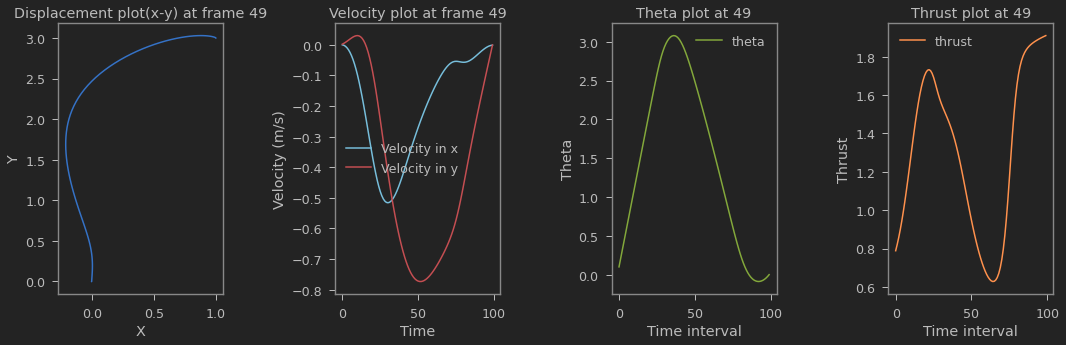

[51] loss: 0.000


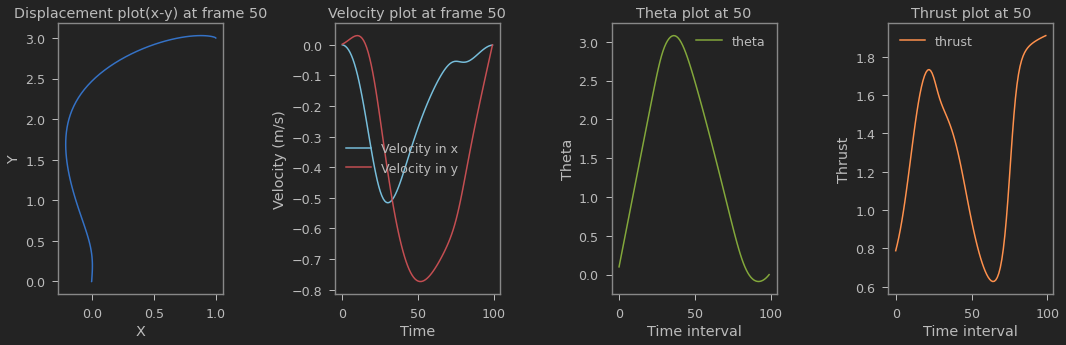

[52] loss: 0.000


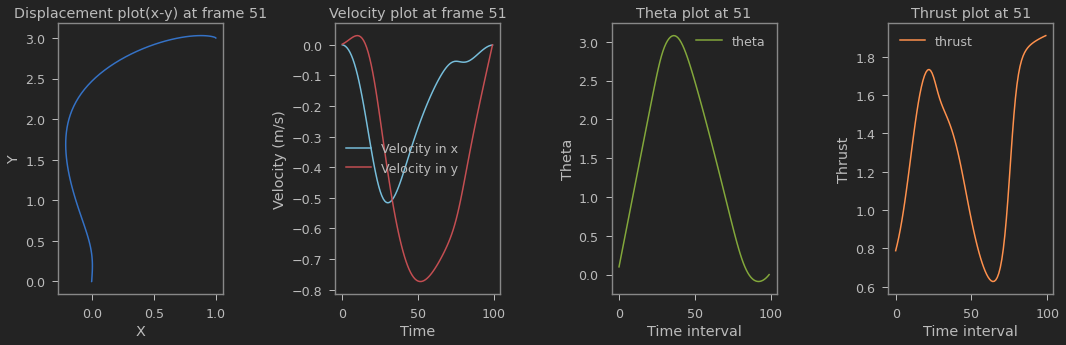

[53] loss: 0.000


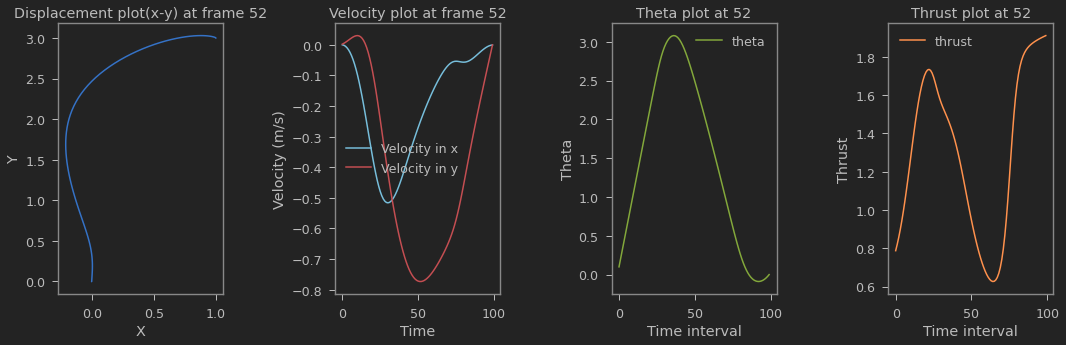

[54] loss: 0.000


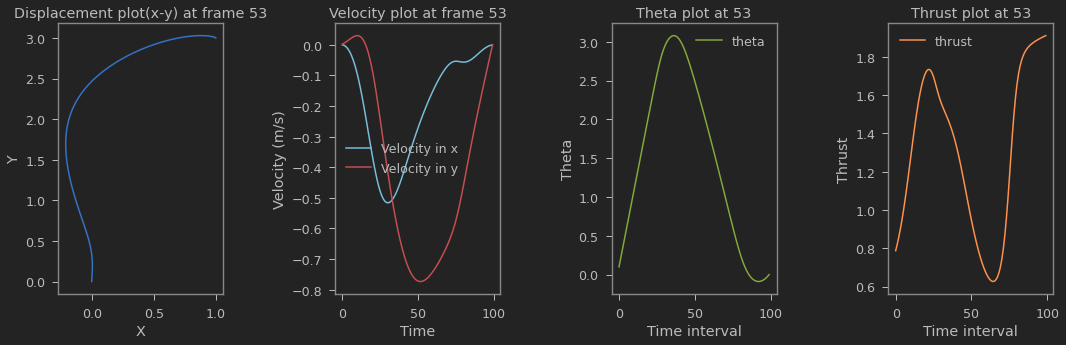

[55] loss: 0.000


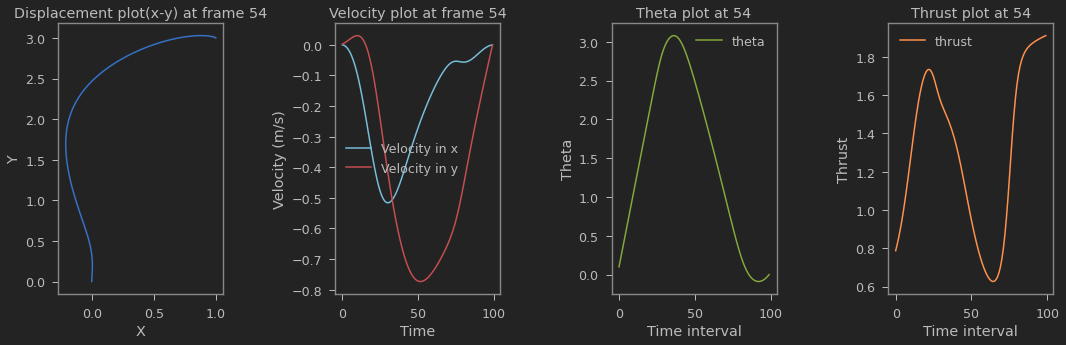

[56] loss: 0.000


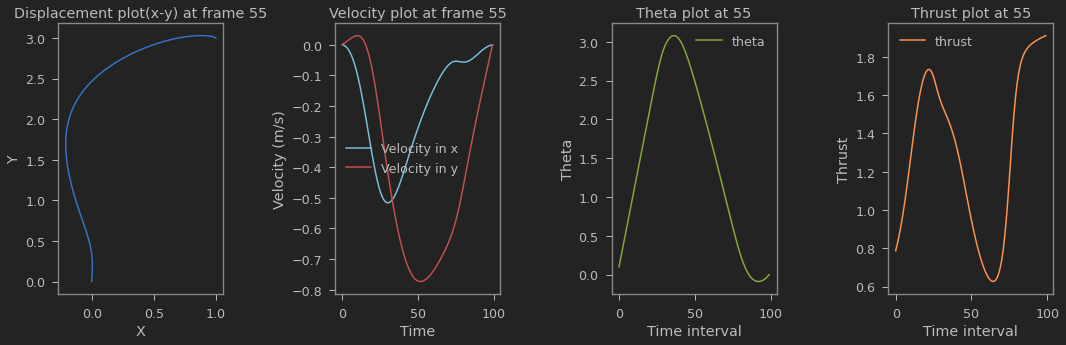

[57] loss: 0.000


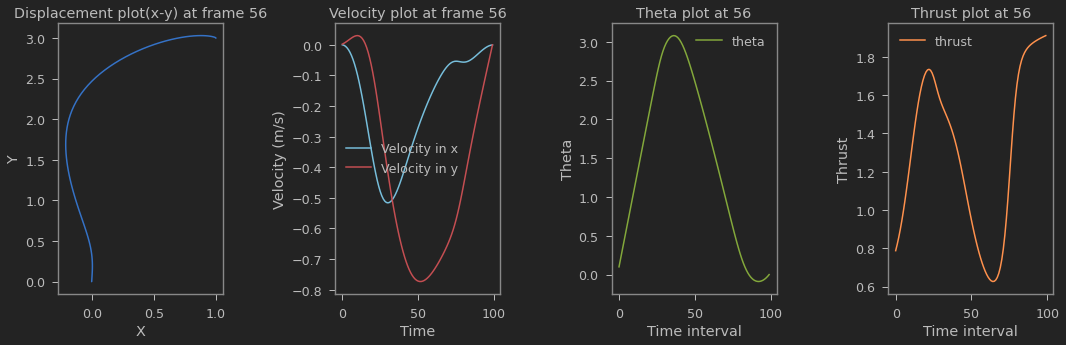

[58] loss: 0.000


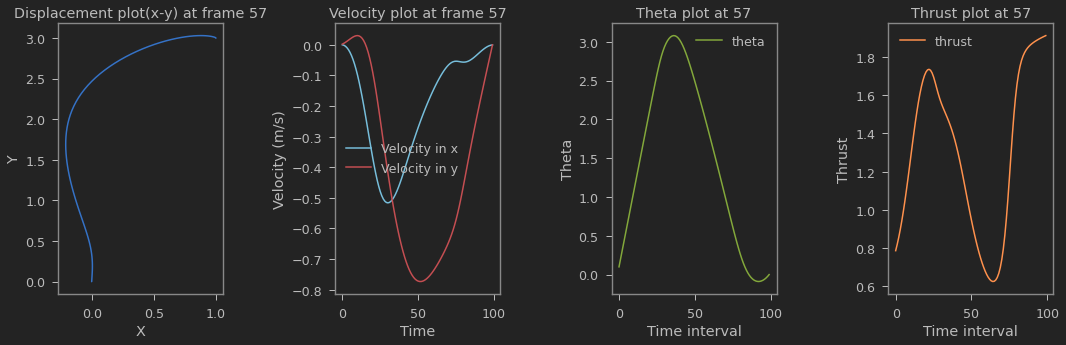

[59] loss: 0.000


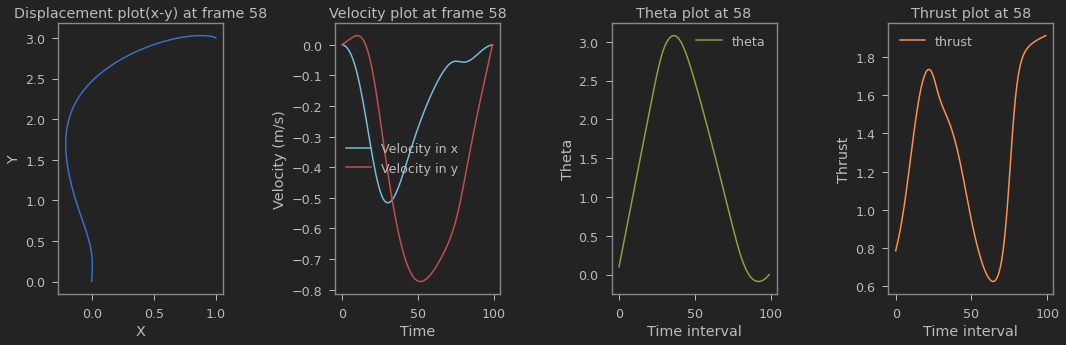

[60] loss: 0.000


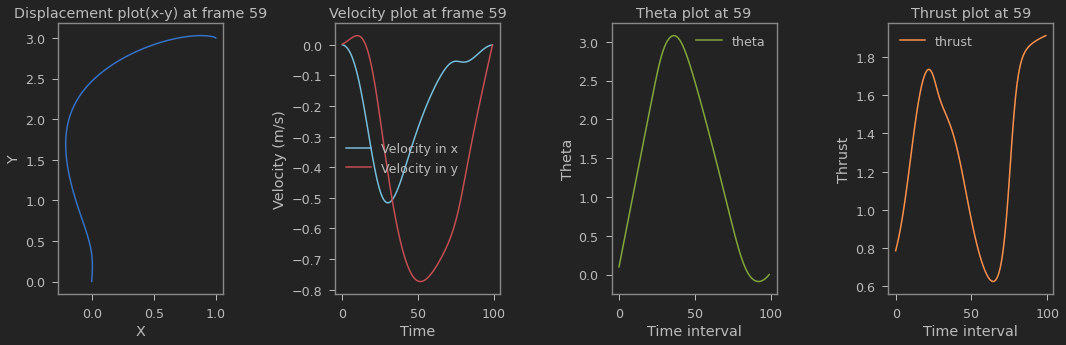

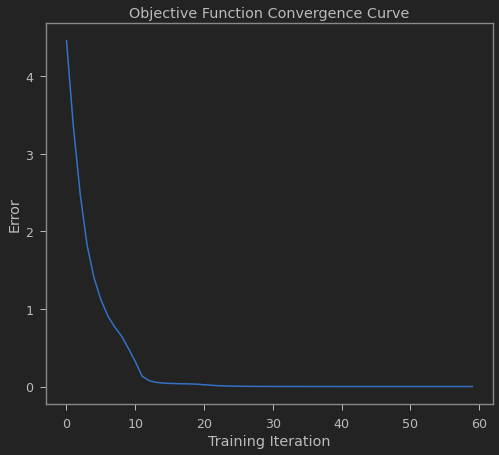

Generating Animation


IntProgress(value=0, max=101)

(100, 5) (100, 2)


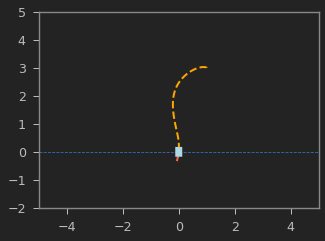

In [30]:
T = 100  # number of time steps
dim_input = 5  # state space dimensions
dim_hidden = 6  # latent dimensions
dim_output = 2  # action space dimensions
d = Dynamics()  
c = Controller(dim_input, dim_hidden, dim_output)  
s = Simulation(c, d, T)  
o = Optimize(s)  
o.train(60)  # training with number of epochs

# **Discussions**
As we can see the controller was able to successfully control the model as the loss converge to zero 0 : all the variables converge goal state.

From the resulting graphs, the following can be observed:


*   Loss at the first frame much higher ~1.9 but the loss decreases throughout the iterations which is the good thing.

*   We can see the thrust value in frame 24 is much efficient as compared to frame 0.

*   I also found that the model is not realistic because there are no constraints for acceleration and turning rate. i.e. we can generate whatever force we want. And y can be smaller than 0, which means the rocket can go into the ground.










# **What next**
We will need to formulate the rocket landing problem considering a number of Constraints; as follows
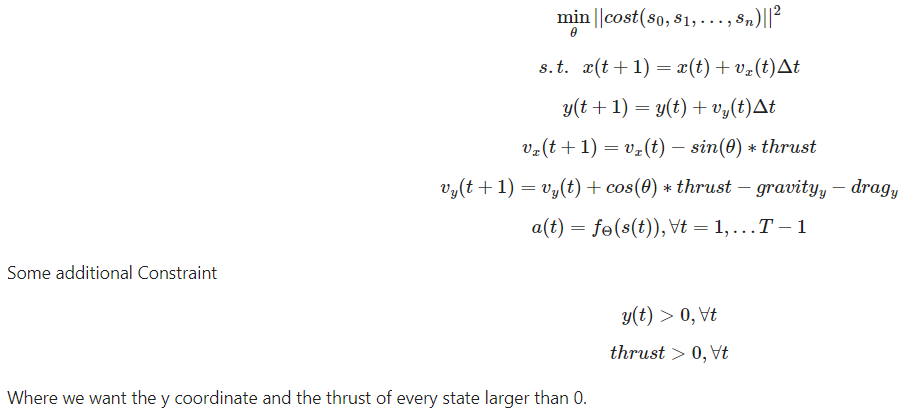
